In [13]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks
## Session 26a

##  Convolutional Neural Network (CNN) DenseNet
<img src='../../images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

<img src='images/dense_net.png' style = 'width:1200px;' alt="densenet" align="left"/>

In [14]:
### Import Libraries

import tensorflow as tf

import os

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


import tensorflow as tf


%matplotlib inline

In [15]:
# Some basic parameters

inpDir = '../input' # location where input data is stored
outDir = '../output' # location to store outputs
subDir = 'flower_photos' # location of the images
modelDir = '../models'
valDir = 'flowers_validation'
altName = 'densenet_flowers'


RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production

EPOCHS = 100 # number of cycles to run

BATCH_SIZE = 32

ALPHA = 0.1


TEST_SIZE = 0.2

IMG_HEIGHT = 200

IMG_WIDTH = 200

FLIP_MODE = "horizontal_and_vertical"

# for rotation transformation
ROTATION_FACTOR = (-0.1, 0.1)
FILL_MODE = 'nearest'

ES_PATIENCE = 10 # if performance does not improve stop

LR_PATIENCE = 5 # if performace is not improving reduce alpha

LR_FACTOR = 0.8 # rate of reduction of alpha


# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,4),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

## Helper Function

In [16]:
def fn_plot_hist(hist_df):

    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)

    ax = axes[0]

    hist_df.plot(y = [hist_df.columns[0],hist_df.columns[2]], ax = ax, colormap=CMAP)

    lossmin = hist_df[hist_df.columns[0]].min()

    testmin = hist_df[hist_df.columns[2]].min()

    # little beautification
    txtstr = "Min {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[0],
                                                                          lossmin,
                                                                          testmin) #text to plot

    # place a text box in upper left in axes coords

    ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")

    ax.set_ylabel(hist_df.columns[0].capitalize())

    ax.grid();

    ax = axes[1]

    hist_df.plot( y = [hist_df.columns[1], hist_df.columns[3]], ax = ax, colormap=CMAP)

    # little beautification
    accmin = hist_df[hist_df.columns[1]].max()
    testmin = hist_df[hist_df.columns[3]].max()
    txtstr = "Max {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[1],
                                                                                accmin,
                                                                                testmin) #text to plot

    # place a text box in upper left in axes coords

    ax.text(0.4, 0.5, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")
    ax.set_ylabel(hist_df.columns[1].capitalize())
    ax.grid();
    plt.tight_layout()

In [17]:
def fn_plot_label(tr_ds, ts_ds):

    plt.subplot(1,2,1)

    train_labels = np.concatenate([y for x, y in tr_ds], axis=0).squeeze()

    unique, counts = np.unique(train_labels, return_counts=True)

    plt.bar(range(len(unique)), counts, align='center',color = 'DarkBlue', alpha = 0.8)

    plt.title('Training Set')

    plt.xticks(range(len(unique)), class_names);


    plt.subplot(1,2,2)

    val_labels = np.concatenate([y for x, y in ts_ds], axis=0).squeeze()

    unique, counts = np.unique(val_labels, return_counts=True)

    plt.bar(range(len(unique)), counts, align='center', color = 'Orange', alpha = 0.8)

    plt.title('Validation Set')

    plt.xticks(range(len(unique)), class_names);

In [18]:
from tensorflow.keras.applications import DenseNet169

## Load Dataset

Images are under flower_photos

     |- daisy
     |- dandelion
     |- roses
     |- sunflowers
     |- tulips

In [19]:
data_dir = os.path.join(inpDir, subDir)

In [20]:
data_dir

'../input/flower_photos'

In [21]:
### For Colab Users only.

In [22]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 2s 0us/step


In [23]:
# load data and split in training and validation from a sub dir

# training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=TEST_SIZE,
    subset="training",
    seed=RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=TEST_SIZE,
    subset="validation",
    seed=RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [24]:
#!ls '../input/valid_flowers'

### Is it picking the class names?

In [25]:
class_names = train_ds.class_names
print('total ', len(class_names), class_names)

total  5 ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Verify the data

To verify that the dataset looks correct, let's plot a batch from the training set and display the class name below each image.


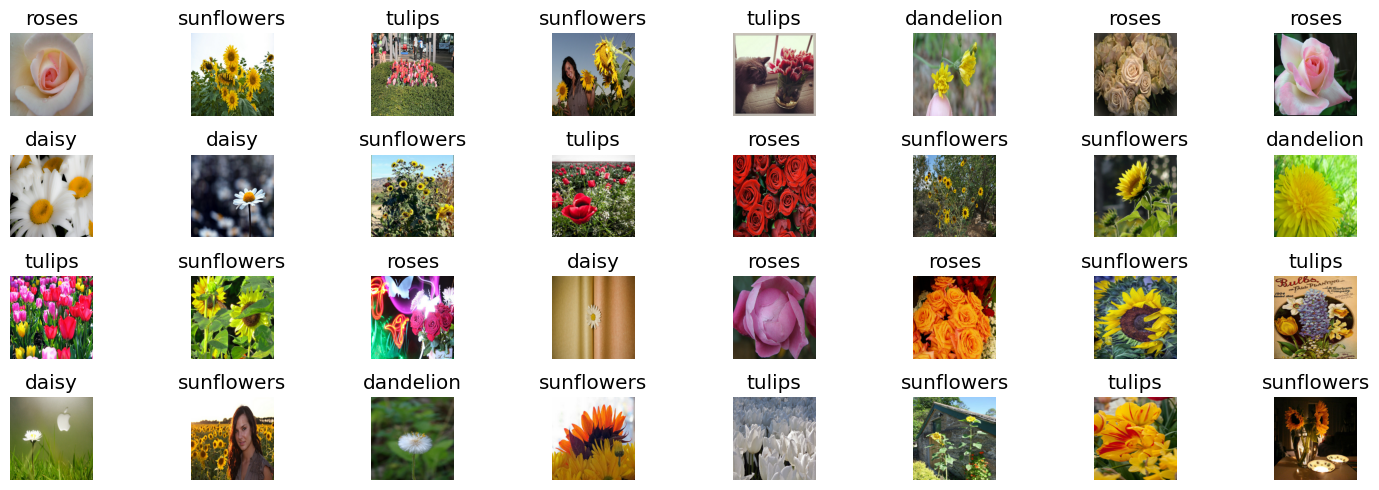

In [26]:
plt.figure(figsize=(15,5))

for images, labels in train_ds.take(1): # gets a batch of first BATCH_SIZE images

    for i in range(BATCH_SIZE):

        plt.subplot(int(BATCH_SIZE/8), 8, i+1)

        plt.grid(False)

        plt.imshow(images[i].numpy().astype("uint8")) # image_size has converted these images to float

        plt.title(class_names[labels[i]])

        plt.axis("off")

    plt.tight_layout()

    plt.show()

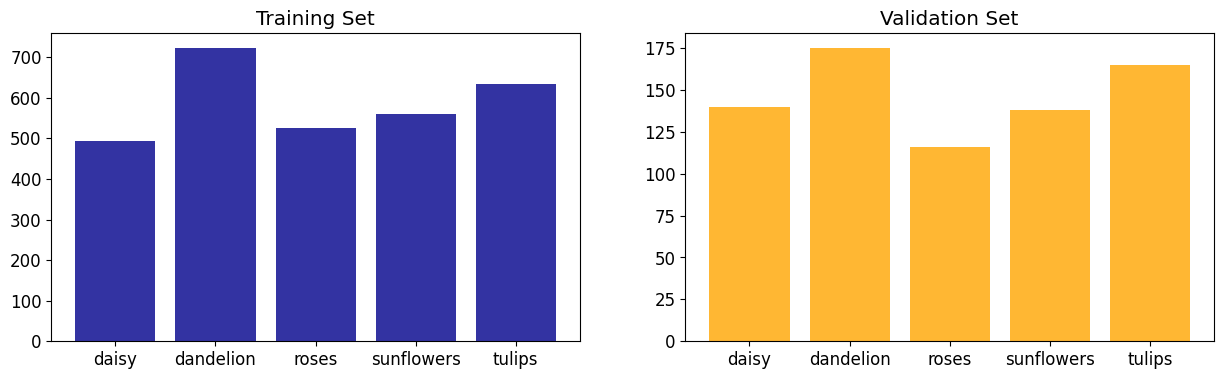

In [27]:
fn_plot_label(train_ds, test_ds)

### Input shape

If we plan to use input layer, we need input shape. Alternatively, we use `.build()` on the model and let framework capture input shape from the data

In [28]:
images[i].shape

TensorShape([200, 200, 3])

In [29]:
normalization_layer = tf.keras.layers.Rescaling(1./255.)

img_batch, l_batch = next(iter(train_ds))

img = img_batch[0]

print (np.max(img), np.min(img))

train_ds = train_ds.map(lambda X, y: (normalization_layer(X), y) )
test_ds = test_ds.map(lambda X, y: (normalization_layer(X), y) )

img_batch, l_batch = next(iter(train_ds))

img = img_batch[0]
print (np.max(img), np.min(img))

255.0 0.0
1.0 0.0


In [30]:
## Optimize for performance

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [31]:
densenet_model = tf.keras.applications.DenseNet169(weights='imagenet',
                                                   include_top=False,
                                                   input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

51877672/51877672 [==============================] - 0s 0us/step


In [32]:
for layer in densenet_model.layers:
    layer.trainable = False

In [33]:
densenet_model.summary()

Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 206, 206, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 100, 100, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 100, 100, 64)         256       ['conv1/conv[0][0]']

In [34]:
num_classes = len(class_names)

In [35]:
# Create Model objecct
def build_model(d_model, n_classes):

    krnl_init = tf.keras.initializers.GlorotUniform(
                                       seed=RANDOM_STATE )


    model = tf.keras.Sequential()

    # Scaling all images between 0 and 1
    #model.add(tf.keras.layers.Rescaling(1./255))

    # Data Augumentation


    model.add(densenet_model)  # 6x6 X 1664


    model.add(tf.keras.layers.Dropout(0.1))

    model.add(tf.keras.layers.Conv2D(1664, (3, 3),
                                     kernel_initializer = krnl_init,
                                     activation='relu'))   # 4x4
    # model.add(layers.BatchNormalization())

    #model.add(tf.keras.layers.Conv2D(5, (4, 4)))            # using 4x4 kernel to see the complete image

    model.add(tf.keras.layers.Flatten())

    # First Dense set
    model.add(tf.keras.layers.Dense(1024,
                                    kernel_initializer = krnl_init,
                                    activation='relu'))
    model.add(tf.keras.layers.Dropout(0.1))


    # output layer
    model.add(tf.keras.layers.Dense(n_classes,
                                  kernel_initializer = krnl_init
                                  ))

    #Using softmax activation function at the last layer which is used for multi class classification
    #model.add(tf.keras.layers.Activation('softmax'))

    return model

In [36]:
model = build_model(densenet_model,num_classes)

In [37]:
# Directory where the checkpoints will be saved
checkpoint_dir = os.path.join(modelDir, subDir)

# Early Stopping
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  restore_best_weights=True,
                                                  patience=ES_PATIENCE,
                                                  verbose=1)


# Reduction schedukle for alpha
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=LR_FACTOR,
                                                 patience=LR_PATIENCE)


checkpoint_prefix = os.path.join(checkpoint_dir, altName)

# Save weights
model_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                                    monitor='val_loss',
                                                    mode='auto',
                                                    save_weights_only=True,
                                                    save_best_only=True,
                                                    verbose=1)

In [38]:
#alpha = ALPHA
alpha = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=alpha),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,
                    validation_data=test_ds,
                    callbacks=[ early_callback, model_callback, lr_reduce],
                    epochs=EPOCHS)

Epoch 1/100
48/92 [==============>...............] - ETA: 7:01 - loss: 6.7307 - accuracy: 0.7155

In [ ]:
model.summary()

In [ ]:
#tf.keras.utils.plot_model(model, "flowers_model.png")

In [ ]:
res_df = pd.DataFrame(history.history)
res_df

In [ ]:
fn_plot_hist(res_df)

### Evaluate the model

In [ ]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1)

In [ ]:
yhat = model.predict(test_ds)

In [ ]:
y_test = np.concatenate([y for X, y in test_ds], axis=0).squeeze()

In [ ]:
y_pred = yhat.argmax(axis = 1)

print('Accuracy score on Test Data : {:.4f}'.format(accuracy_score(y_test, y_pred)))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=class_names)

fig, ax = plt.subplots(figsize = (9,9))
disp.plot(ax = ax, cmap=plt.cm.Blues);
ax.set_xticklabels(class_names,rotation=45, ha='right');

In [ ]:
for images, labels in test_ds.take( 5 ):

    for i in range ( BATCH_SIZE ):

        plt.subplot(int( BATCH_SIZE / 8 ), 8, i+1 )

        plt.grid(False)

        plt.imshow ( images[i].numpy())

        plt.title('{} \n {}'.format( class_names[labels.numpy()[i]], class_names[y_pred[i]]))

        plt.axis("off")

    plt.tight_layout()

    plt.show()

In [ ]:
model_path = checkpoint_prefix+'.h5'
model.save(model_path, save_format='h5')

new_model = tf.keras.models.load_model(model_path)

new_model.summary()

In [ ]:
yhat = new_model.predict(test_ds)

y_pred = yhat.argmax(axis = 1)

print('Accuracy score on Test Data : {:.4f}'.format( accuracy_score(y_test, y_pred)))

## Running on Validation Dataset

In [ ]:
val_dir = os.path.join(inpDir, valDir)



val_ds = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                     validation_split=None,
                                                     seed=RANDOM_STATE,
                                                     image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     batch_size=BATCH_SIZE)

In [ ]:
plt.figure(figsize=(15,5))

for images, labels in val_ds.take(1): # gets a batch of first BATCH_SIZE images

    for i in range(BATCH_SIZE):

        plt.subplot(int(BATCH_SIZE/8), 8, i+1)

        plt.grid(False)

        plt.imshow(images[i].numpy().astype("uint8")) # image_size has converted these images to float

        plt.title(class_names[labels[i]])

        plt.axis("off")

    plt.tight_layout()

    plt.show()

In [ ]:
val_ds = val_ds.map(lambda X, y: (normalization_layer(X), y) )

In [ ]:
## Optimize for performance
AUTOTUNE = tf.data.AUTOTUNE

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
test_loss, test_acc = new_model.evaluate(val_ds, verbose=1)

In [ ]:
yhat = new_model.predict(val_ds)

y_pred = yhat.argmax(axis = 1)

y_test = np.concatenate([y for x, y in val_ds], axis=0).squeeze()

print('Accuracy score on Test Data :{:.4f}'.format(accuracy_score(y_test, y_pred)) )

In [ ]:
for images, labels in val_ds.take( 5 ):

    for i in range ( BATCH_SIZE ):

        plt.subplot(int( BATCH_SIZE / 8 ), 8, i+1 )

        plt.grid(False)

        plt.imshow ( images[i].numpy())

        plt.title('{} \n {}'.format( class_names[labels.numpy()[i]], class_names[y_pred[i]]))

        plt.axis("off")

    plt.tight_layout()

    plt.show()